<h2> DL Lab 9
<br>
<h3> Mukul Shingwani
<br>
<h3> B20AI023

<h3> References <br>

[https://colab.research.google.com/drive/1BRr-nL5pevvrjY1SXAV0XfZ9OHKq1DGW?usp=share_link](https://colab.research.google.com/drive/1BRr-nL5pevvrjY1SXAV0XfZ9OHKq1DGW?usp=share_link)

[https://github.com/pytorch-ignite/examples/blob/main/tutorials/intermediate/cifar10-distributed.py](https://github.com/pytorch-ignite/examples/blob/main/tutorials/intermediate/cifar10-distributed.py)

In [2]:
pip install fire

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=2e24788c64893763ca96cac53746f36829bf75e1981d7d86571dfe08dff78b72
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire


In [3]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 7.3 MB/s eta 0:00:00


In [4]:
pip install clearml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [5]:
import fire
from datetime import datetime
from pathlib import Path
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torchvision.transforms import (
    Compose,
    Normalize,
    Pad,
    RandomCrop,
    RandomHorizontalFlip,
    ToTensor,
)
from ignite.handlers import Checkpoint
from pathlib import Path
import ignite
import ignite.distributed as idist
from ignite.contrib.engines import common
from ignite.handlers import PiecewiseLinear
from ignite.engine import (
    Events,
    create_supervised_trainer,
    create_supervised_evaluator,
)
from ignite.handlers import Checkpoint, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.utils import manual_seed, setup_logger
import time

import torch.nn as nn

import torchvision
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor, Normalize
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Accuracy
from ignite.contrib.engines import common
from ignite.contrib.handlers import PiecewiseLinear
from ignite.contrib.handlers.param_scheduler import LinearCyclicalScheduler

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss

<ipython-input-5-2a78965f975d>:46: DeprecationWarning: /usr/local/lib/python3.9/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  from ignite.contrib.handlers.param_scheduler import LinearCyclicalScheduler


# DDP

In [ ]:
def get_train_test_datasets(path):
    # Define the train and test transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load the datasets
    train_ds = torchvision.datasets.SVHN(root=path, split='train', transform=train_transform, download=True)
    test_ds = torchvision.datasets.SVHN(root=path, split='test', transform=test_transform, download=True)

    return train_ds, test_ds


In [ ]:
def get_dataflow(config):
    train_dataset, test_dataset = get_train_test_datasets(config["data_path"])
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=config["num_workers"],
        drop_last=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=config["num_workers"]
    )

    return train_loader, test_loader


def get_model(config):
    model_name = config["model"]
    
    try:
        model = getattr(models, model_name)(num_classes=10)
    except AttributeError:
        raise RuntimeError(f"Unknown model name {model_name}")
    
    return model

def get_optimizer(config, model):
    optimizer_params = {
        "lr": config["learning_rate"],
        "momentum": config["momentum"],
        "weight_decay": config["weight_decay"],
        "nesterov": True,
    }
    
    optimizer = optim.SGD(model.parameters(), **optimizer_params)
    optimizer = idist.auto_optim(optimizer)

    return optimizer


def get_criterion():
    return nn.CrossEntropyLoss().to(idist.device())


from ignite.handlers import Checkpoint
from pathlib import Path

def get_lr_values(config):
    lr_values = []
    for epoch in range(1, config["num_epochs"]+1):
        if epoch <= config["num_warmup_epochs"]:
            lr = epoch * config["learning_rate"] / config["num_warmup_epochs"]
        else:
            lr = config["learning_rate"] * (1 - (epoch - config["num_warmup_epochs"]) / (config["num_epochs"] - config["num_warmup_epochs"]))

        lr_values.append(lr)
    return lr_values

def get_lr_scheduler(config, optimizer):
    lr_values = get_lr_values(config)
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: lr_values[epoch-1])
    return lr_scheduler

def get_save_handler(config):
    if config["with_clearml"]:
        from ignite.contrib.handlers.clearml_logger import ClearMLSaver

        return ClearMLSaver(dirname=config["output_path"])

    return ModelCheckpoint(
        dirname=config["output_path"],
        filename_prefix="model_",
        save_interval=config["save_interval"],
        n_saved=config["n_saved"],
        create_dir=True,
        save_as_state_dict=True
    )



def load_checkpoint(resume_from):
    checkpoint_fp = Path(resume_from)
    assert (
        checkpoint_fp.exists()
    ), f"Checkpoint '{checkpoint_fp.as_posix()}' is not found"
    checkpoint = torch.load(checkpoint_fp.as_posix(), map_location="cpu")
    return checkpoint


def create_trainer(model, optimizer, loss_fn, device, non_blocking=True):
    def train_step(engine, batch):
        model.train()
        optimizer.zero_grad()
        x, y = batch[0].to(device, non_blocking=non_blocking), batch[1].to(device, non_blocking=non_blocking)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        return {"loss": loss.item()}

    trainer = Engine(train_step)
    return trainer


def create_evaluator(model, metrics=None, device=None, non_blocking=True):
    metrics = metrics or {}

    def eval_step(engine, batch):
        model.eval()
        with torch.no_grad():
            x, y = batch[0].to(device, non_blocking=non_blocking), batch[1].to(device, non_blocking=non_blocking)
            y_pred = model(x)
            output = {"y_pred": y_pred, "y": y}
            for name, metric_fn in metrics.items():
                output[name] = metric_fn(y_pred, y).item()
            return output

    evaluator = Engine(eval_step)
    return evaluator



def setup_checkpoint(config, trainer):
    save_handler = get_save_handler(config)
    checkpoint = {"trainer": trainer}
    to_save = {"model": trainer.state_dict(), "optimizer": trainer.state_dict()["optimizer"]}
    trainer.add_event_handler(Events.EPOCH_COMPLETED, Checkpoint(to_save, save_handler))
    return checkpoint



def create_trainer(model, optimizer, criterion, lr_scheduler, train_sampler, config, logger):
    device = idist.device()
    scaler = GradScaler(enabled=config["with_amp"])
    amp_mode = "amp" if config["with_amp"] else None

    def update_fn(engine, batch):
        model.train()
        optimizer.zero_grad()
        x, y = prepare_batch(batch, device=device, non_blocking=True)
        with autocast(enabled=config["with_amp"]):
            y_pred = model(x)
            loss = criterion(y_pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        return {"batch loss": loss.item()}

    trainer = Engine(update_fn)

    trainer.logger = logger
    to_save = {
        "trainer": trainer,
        "model": model,
        "optimizer": optimizer,
        "lr_scheduler": lr_scheduler,
    }

    common.setup_common_training_handlers(
        trainer=trainer,
        train_sampler=train_sampler,
        to_save=to_save,
        save_every_iters=config["checkpoint_every"],
        save_handler=get_save_handler(config),
        lr_scheduler=lr_scheduler,
        with_pbars=False,
        clear_cuda_cache=False,
    )

    if config["resume_from"] is not None:
        checkpoint = load_checkpoint(config["resume_from"])
        Checkpoint.load_objects(to_load=to_save, checkpoint=checkpoint)

    return trainer

def create_evaluator(model, metrics, configs):
    device = torch.device(configs["device"])
    amp_mode = "amp" if configs["with_amp"] else None

    def evaluate_step(engine, batch):
        model.eval()
        with torch.no_grad():
            x, y = prepare_batch(batch, device=device)
            y_pred = model(x)
            return y_pred, y

    evaluator = Engine(evaluate_step)
    for name, metric in metrics.items():
        metric.attach(evaluator, name)

    return evaluator


def setup_rank_zero(logger, configs):
    now = datetime.now().strftime("%Y%m%d-%H%M%S")
    output_path = configs["output_path"]
    folder_name = (
        f"{configs['model']}_backend-{torch.distributed.get_backend()}_{now}"
    )
    output_path = Path(output_path) / folder_name
    if not output_path.exists():
        output_path.mkdir(parents=True)
    configs["output_path"] = output_path.as_posix()
    logger.info(f"Output path: {configs['output_path']}")

    if configs["with_clearml"]:
        from clearml import Task

        task = Task.init("SVHN-Training", task_name=output_path.stem)
        task.connect_configuration(configs)
        # Log hyper parameters
        hyper_params = [
            "model",
            "batch_size",
            "momentum",
            "weight_decay",
            "num_epochs",
            "learning_rate",
            "num_warmup_epochs",
        ]
        task.connect({k: v for k, v in configs.items()})

def log_basic_info(logger, config):
    gpu_info = ""
    if torch.cuda.is_available():
        from torch.backends import cudnn

        gpu_info = f"- GPU Device: {torch.cuda.get_device_name()} \n" \
                   f"- CUDA version: {torch.version.cuda} \n" \
                   f"- CUDNN version: {cudnn.version()} \n"
        
    logger.info("Train on SVHN")
    logger.info(f"- PyTorch version: {torch.__version__}")
    logger.info(f"- Ignite version: {ignite.__version__}")
    logger.info(gpu_info)

    logger.info("\nConfiguration:")
    for key, value in config.items():
        logger.info(f"\t{key}: {value}")
    logger.info("\n")

    if idist.get_world_size() > 1:
        logger.info("\nDistributed setting:")
        logger.info(f"\tbackend: {idist.backend()}")
        logger.info(f"\tworld size: {idist.get_world_size()}")
        logger.info("\n")


def log_metrics(logger, epoch, elapsed, tag, metrics):
    metrics_output = "\n".join([f"\t{k}: {v}" for k, v in metrics.items()])
    log_msg = f"\nEpoch {epoch} - Evaluation time (seconds): {elapsed:.2f} - {tag} metrics:\n {metrics_output}"
    logger.info(log_msg)



def training(local_rank, config):
    rank = idist.get_rank()
    manual_seed(config["seed"] + rank)
    
    logger = setup_logger(name="CIFAR10-Training")
    log_basic_info(logger, config)
    
    if rank == 0:
        setup_rank_zero(logger, config)
    
    train_loader, val_loader = get_dataflow(config)
    model = get_model(config)
    optimizer = get_optimizer(config, model)
    criterion = get_criterion()
    config["num_iters_per_epoch"] = len(train_loader)
    lr_scheduler = get_lr_scheduler(config, optimizer)

    trainer = create_trainer(model, optimizer, criterion, lr_scheduler, train_loader.sampler, config, logger)
    train_evaluator = create_evaluator(model, {"Accuracy": Accuracy(), "Loss": Loss(criterion)}, config)
    val_evaluator = create_evaluator(model, {"Accuracy": Accuracy(), "Loss": Loss(criterion)}, config)

    @trainer.on(Events.EPOCH_COMPLETED(every=config["validate_every"]) | Events.COMPLETED)
    def run_validation(engine):
        epoch = engine.state.epoch
        train_metrics = train_evaluator.run(train_loader).metrics
        val_metrics = val_evaluator.run(val_loader).metrics
        log_metrics(logger, epoch, engine.state.times["COMPLETED"], "train", train_metrics)
        log_metrics(logger, epoch, engine.state.times["COMPLETED"], "val", val_metrics)

    best_model_handler = Checkpoint(
        {"model": model},
        get_save_handler(config),
        filename_prefix="best",
        n_saved=2,
        global_step_transform=global_step_from_engine(trainer),
        score_name="val_accuracy",
        score_function=Checkpoint.get_default_score_fn("Accuracy"),
    )

    val_evaluator.add_event_handler(Events.COMPLETED, best_model_handler)
    
    if rank == 0:
        evaluators = {"train": train_evaluator, "val": val_evaluator}
        tb_logger = common.setup_tb_logging(
            config["output_path"], trainer, optimizer, evaluators=evaluators
        )

    try:
        trainer.run(train_loader, max_epochs=config["num_epochs"])
    except Exception as e:
        logger.exception("")
        raise e
    
    if rank == 0:
        tb_logger.close()


def run(backend=None, **spawn_kwargs):
    config["backend"] = backend

    with idist.Parallel(backend=config["backend"], **spawn_kwargs) as parallel:
        parallel.run(training, config)


## batch size = 32, 1 gpu node

In [ ]:
config = {
    "seed": 42,
    "data_path": "svhn",
    "output_path": "output-svhn/",
    "model": "resnet18",
    "batch_size": 32,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "num_workers": 2,
    "num_epochs": 30,
    "learning_rate": 3e-4,
    "num_warmup_epochs": 1,
    "validate_every": 1,
    "checkpoint_every": 200,
    "backend": None,
    "resume_from": None,
    "log_every_iters": 15,
    "nproc_per_node": None,
    "with_clearml": False,
    "with_amp": False,
}

In [ ]:
spawn_kwargs = {}
spawn_kwargs["start_method"] = "fork"
spawn_kwargs["nproc_per_node"] = 1 #number of GPU nodes
config["backend"] = "nccl"

with idist.Parallel(backend=config["backend"], **spawn_kwargs) as parallel:
    parallel.run(training, config)

2023-04-22 06:06:06,625 ignite.distributed.launcher.Parallel INFO: Initialized distributed launcher with backend: 'nccl'
2023-04-22 06:06:06,627 ignite.distributed.launcher.Parallel INFO: - Parameters to spawn processes: 
	nproc_per_node: 1
	nnodes: 1
	node_rank: 0
	start_method: fork
2023-04-22 06:06:06,629 ignite.distributed.launcher.Parallel INFO: Spawn function '<function training at 0x7f8405ec94c0>' in 1 processes
2023-04-22 06:06:08,402 CIFAR10-Training INFO: Train on SVHN
2023-04-22 06:06:08,405 CIFAR10-Training INFO: - PyTorch version: 2.0.0+cu118
2023-04-22 06:06:08,406 CIFAR10-Training INFO: - Ignite version: 0.4.11
2023-04-22 06:06:08,409 CIFAR10-Training INFO: - GPU Device: Tesla T4
2023-04-22 06:06:08,414 CIFAR10-Training INFO: - CUDA version: 11.8
2023-04-22 06:06:08,417 CIFAR10-Training INFO: - CUDNN version: 8700
2023-04-22 06:06:08,419 CIFAR10-Training INFO: 

2023-04-22 06:06:08,420 CIFAR10-Training INFO: Configuration:
2023-04-22 06:06:08,424 CIFAR10-Training INFO: 	

100%|██████████| 182040794/182040794 [00:07<00:00, 24964516.03it/s]


100%|██████████| 64275384/64275384 [00:02<00:00, 23379874.18it/s]
2023-04-22 06:06:23,463 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset SVHN
    Num': 
	{'batch_size': 32, 'num_workers': 2, 'shuffle': True, 'drop_last': True, 'pin_memory': True}
2023-04-22 06:06:23,476 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset SVHN
    Num': 
	{'batch_size': 64, 'num_workers': 2, 'shuffle': False, 'pin_memory': True}
2023-04-22 06:06:28,497 CIFAR10-Training INFO: Engine run starting with max_epochs=30.
2023-04-22 06:08:03,566 CIFAR10-Training INFO: 
Epoch 1 - Evaluation time (seconds): 33.06 - train metrics:
 	Accuracy: 0.5569435342944518
	Loss: 1.3001148495522061
2023-04-22 06:08:13,089 CIFAR10-Training INFO: 
Epoch 1 - Evaluation time (seconds): 9.46 - val metrics:
 	Accuracy: 0.5506299938537185
	Loss: 1.3297124392574524
2023-04-22 06:08:13,091 CIFAR10-Training INFO: Epoch[1] Complete. Time taken: 00:01:44.519

## batch = 42, 2 gpu nodes

In [ ]:
config = {
    "seed": 42,
    "data_path": "svhn",
    "output_path": "output-svhn/",
    "model": "resnet18",
    "batch_size": 64,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "num_workers": 2,
    "num_epochs": 30,
    "learning_rate": 3e-4,
    "num_warmup_epochs": 1,
    "validate_every": 1,
    "checkpoint_every": 200,
    "backend": None,
    "resume_from": None,
    "log_every_iters": 15,
    "nproc_per_node": None,
    "with_clearml": False,
    "with_amp": False,
}

In [ ]:
spawn_kwargs = {}
spawn_kwargs["start_method"] = "fork"
spawn_kwargs["nproc_per_node"] = 2 #number of GPU nodes
config["backend"] = "nccl"

with idist.Parallel(backend=config["backend"], **spawn_kwargs) as parallel:
    parallel.run(training, config)

# Data parallelism

In [ ]:
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler

# Set the number of epochs to train for
num_epochs = 30

# Set the batch size for training and validation
batch_size = 64

# Set the number of workers for the data loaders
num_workers = 2

# Set the initial learning rate
lr_init = 3e-4

# Set the learning rate decay factor
lr_decay = 0.1

# Set the momentum for the optimizer
momentum = 0.9

# Set the weight decay for the optimizer
weight_decay = 5e-4

# Set the number of classes in the dataset
num_classes = 10

# Get the number of GPUs available
num_gpus = torch.cuda.device_count()

print(num_gpus)

# Initialize the model using DistributedDataParallel
model = nn.Sequential(
    torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=False),
    nn.Linear(512, num_classes)
)
model = nn.parallel.DistributedDataParallel(model, device_ids=[i for i in range(num_gpus)])

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr_init,
    momentum=momentum,
    weight_decay=weight_decay,
)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[10, 20],
    gamma=lr_decay,
)

# Define the training and validation transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
test_transform = transforms.Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create the training dataset and data loader
train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=train_transform)
train_sampler = DistributedSampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, sampler=train_sampler)

# Create the validation dataset and data loader
test_ds = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

1


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [ ]:
class PiecewiseLinearWithEpoch(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, milestones, gamma=0.1, last_epoch=-1):
        self.milestones = milestones
        self.gamma = gamma
        super(PiecewiseLinearWithEpoch, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch not in self.milestones:
            return [group['lr'] for group in self.optimizer.param_groups]
        idx = bisect.bisect_right(self.milestones, self.last_epoch)
        last_milestone = self.milestones[idx - 1]
        lr = [group['lr'] for group in self.optimizer.param_groups]
        for i, base_lr in enumerate(lr):
            factor = self.gamma ** (idx * (self.last_epoch - last_milestone))
            lr[i] = base_lr * factor
        return lr


In [ ]:
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = [elem.cuda(non_blocking=True) for elem in batch]
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def eval_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = [elem.cuda(non_blocking=True) for elem in batch]
        y_pred = model(x)
    return y_pred, y


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

# create the trainer engine
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

# create the evaluator engine
evaluator = create_supervised_evaluator(model, metrics={'accuracy': Accuracy(), 'loss': Loss(criterion)}, device=device)

# add the learning rate scheduler to the trainer engine
@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(engine):
    lr_scheduler.step()

# add handlers to print training and validation metrics
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_loss(engine):
    print(f"Train - Epoch {engine.state.epoch}: Loss={engine.state.output:.4f}")

@evaluator.on(Events.EPOCH_COMPLETED)
def log_validation_metrics(engine):
    metrics = engine.state.metrics
    print(f"Validation - Epoch {engine.state.epoch}: Accuracy={metrics['accuracy']:.4f} Loss={metrics['loss']:.4f}")


In [ ]:
# run the training and evaluation loops
total_time = 0
for epoch in range(1, 31):
    start = time.time()
    trainer.run(train_loader)
    evaluator.run(test_loader)
    end = time.time()
    epoch_time = end - start
    total_time += epoch_time
    print(f"Epoch {epoch}: {epoch_time:.2f} seconds")
print(f"Total time taken: {total_time:.2f} seconds")


Train - Epoch 1: Loss=0.4653
Validation - Epoch 1: Accuracy=0.8074 Loss=0.6068
Epoch 1: 43.67 seconds
Train - Epoch 1: Loss=0.5130
Validation - Epoch 1: Accuracy=0.8432 Loss=0.5044
Epoch 2: 45.24 seconds
Train - Epoch 1: Loss=0.4076
Validation - Epoch 1: Accuracy=0.8712 Loss=0.4172
Epoch 3: 44.38 seconds
Train - Epoch 1: Loss=0.4436
Validation - Epoch 1: Accuracy=0.8789 Loss=0.3895
Epoch 4: 43.93 seconds
Train - Epoch 1: Loss=0.6119
Validation - Epoch 1: Accuracy=0.8793 Loss=0.3873
Epoch 5: 45.17 seconds
Train - Epoch 1: Loss=0.1423
Validation - Epoch 1: Accuracy=0.8846 Loss=0.3734
Epoch 6: 44.48 seconds
Train - Epoch 1: Loss=0.1387
Validation - Epoch 1: Accuracy=0.8922 Loss=0.3566
Epoch 7: 44.91 seconds
Train - Epoch 1: Loss=0.2151
Validation - Epoch 1: Accuracy=0.8961 Loss=0.3360
Epoch 8: 45.95 seconds
Train - Epoch 1: Loss=0.3491
Validation - Epoch 1: Accuracy=0.9006 Loss=0.3250
Epoch 9: 46.78 seconds
Train - Epoch 1: Loss=0.2436
Validation - Epoch 1: Accuracy=0.8996 Loss=0.3245
Epo

## Plots

In [ ]:
filename = 'epochs_time_file.txt'
with open(filename, 'r') as f:
    lists = [list(map(float, line.strip().split())) for line in f.readlines()]


In [29]:
train_1_32 = lists[0]
test_1_32 = lists[1]
train_2_64 = lists[2]
test_2_64 = lists[3]
train_time_dp = lists[4]

In [30]:
print(train_1_32)
print(test_1_32)
print(train_2_64)
print(test_2_64)
print(train_time_dp)

[24.25, 25.02, 25.25, 25.27, 25.32, 25.55, 25.94, 26.54, 26.37, 26.45, 26.42, 26.42, 26.46, 26.42, 26.64, 26.54, 26.45, 26.07, 26.3, 26.5, 26.35, 26.44, 26.36, 26.36, 26.41, 26.45, 26.43, 26.34, 26.41, 26.28]
[6.46, 6.59, 6.61, 6.6, 6.53, 6.54, 6.51, 6.44, 6.5, 6.59, 6.47, 6.56, 6.52, 6.52, 6.5, 6.49, 6.44, 6.43, 6.47, 6.47, 6.44, 6.49, 6.47, 6.41, 6.41, 6.5, 6.43, 6.73, 6.41, 6.36]
[19.71, 20.52, 20.62, 20.67, 20.63, 20.7, 20.57, 20.67, 20.79, 20.61, 20.73, 20.49, 20.65, 20.72, 20.77, 20.79, 20.82, 20.45, 20.3, 20.37, 20.24, 20.54, 20.21, 20.35, 20.29, 20.22, 20.24, 20.29, 20.23, 20.56]
[5.19, 5.31, 5.29, 5.31, 5.33, 5.34, 5.37, 5.31, 5.36, 5.34, 5.3, 5.32, 5.31, 5.29, 5.34, 5.39, 5.48, 5.2, 5.34, 5.28, 5.29, 5.18, 5.22, 5.24, 5.25, 5.26, 5.23, 5.22, 5.16, 5.28, 5.17]
[58.91, 45.1, 45.07, 45.16, 45.11, 45.11, 45, 45.17, 45.08, 45.12, 45.15, 45.23, 45.44, 45.14, 45.11, 45.09, 45.6, 45.21, 45.3, 45.11, 45.21, 45.19, 45.26, 45.89, 45.16, 44.5, 44.43, 44.42, 44.39, 44.58]


In [33]:
# this is the actual time taken for running the epochs, so compariison will be based on this
total_time = np.sum(train_1_32) + np.sum(test_1_32)
print('total time for batch 32, 1 gpu nodes is and distributed data parallelism:', total_time, 's')
total_time = 0
total_time = np.sum(train_2_64) + np.sum(test_2_64)
print('total time for batch 64, 2 gpu nodes is and distributed data parallelism:', total_time, 's')

print('total time for bathc 64, 2 gpu nodes with data parallelism:', np.sum(train_time_dp))

total time for batch 32, 1 gpu nodes is and distributed data parallelism: 978.8999999999999 s
total time for batch 64, 2 gpu nodes is and distributed data parallelism: 778.65 s
total time for bathc 64, 2 gpu nodes with data parallelism: 1366.2400000000002


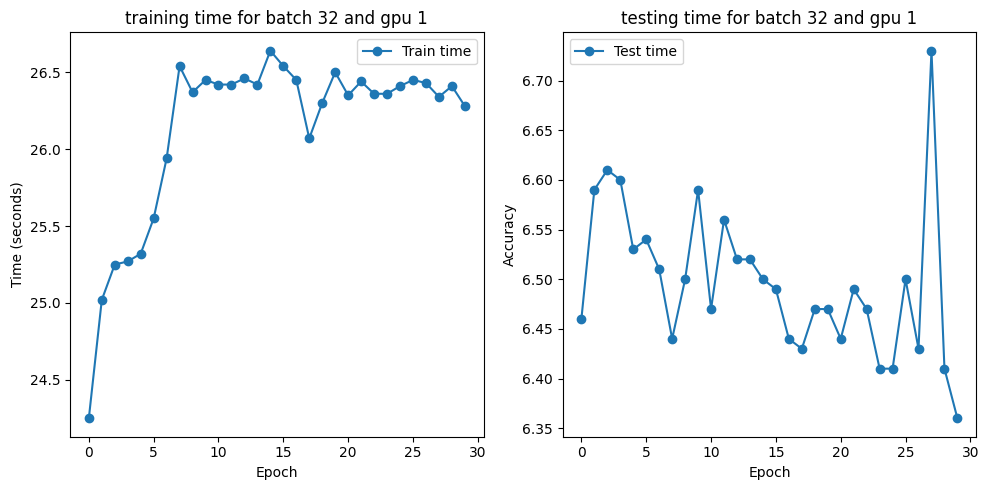

In [11]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure with two subplots in one row and two columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Plot the first graph in the first column
axs[0].plot(train_1_32, '-o', label='Train time')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_title('training time for batch 32 and gpu 1')
axs[0].legend()


axs[1].plot(test_1_32, '-o', label='Test time')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Time (seconds)')
axs[1].set_title('testing time for batch 32 and gpu 1')
axs[1].legend()

# Adjust the layout and spacing
fig.tight_layout()

# Show the plot
plt.show()


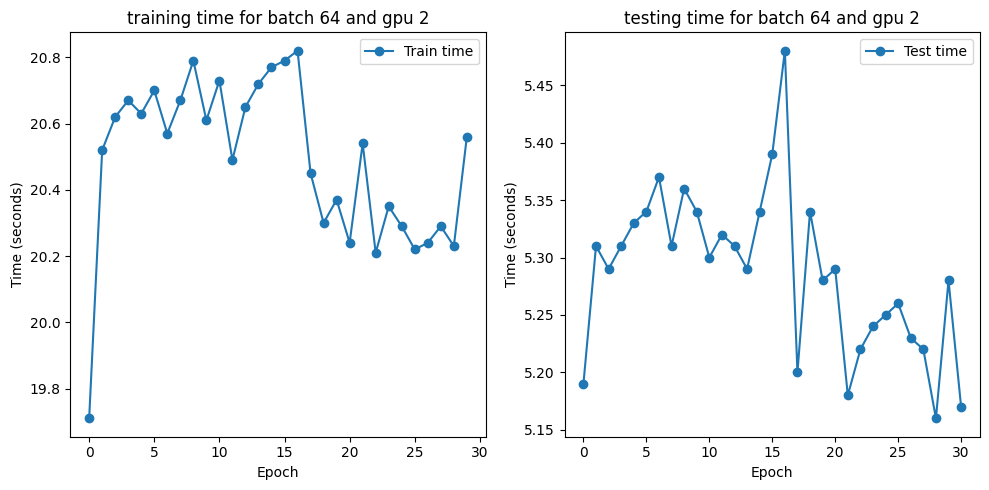

In [16]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure with two subplots in one row and two columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Plot the first graph in the first column
axs[0].plot(train_2_64, '-o', label='Train time')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_title('training time for batch 64 and gpu 2')
axs[0].legend()


axs[1].plot(test_2_64, '-o', label='Test time')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Time (seconds)')
axs[1].set_title('testing time for batch 64 and gpu 2')
axs[1].legend()

# Adjust the layout and spacing
fig.tight_layout()

# Show the plot
plt.show()


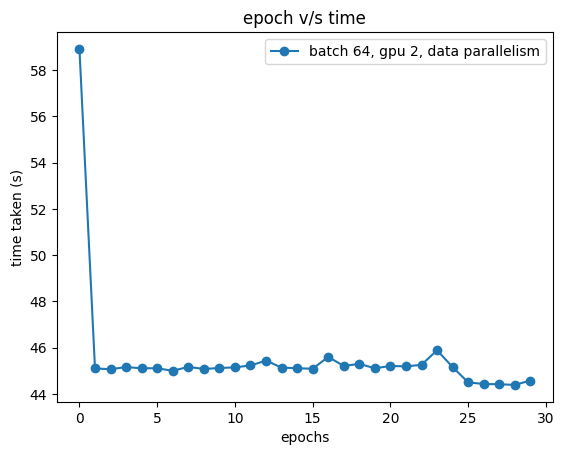

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_time_dp, '-o', label = 'batch 64, gpu 2, data parallelism')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('time taken (s)')
plt.title('epoch v/s time')
plt.show()

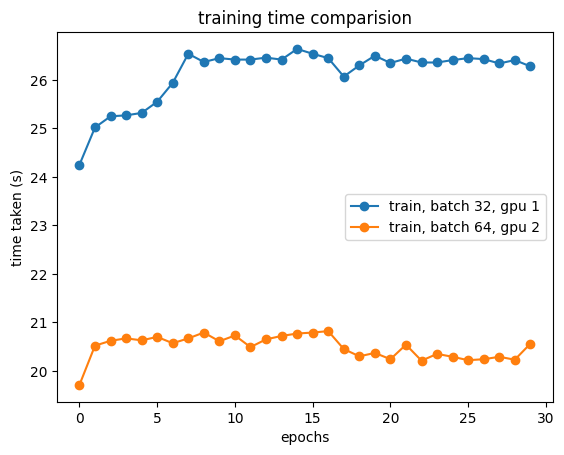

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_1_32, '-o', label = 'train, batch 32, gpu 1')
plt.plot(train_2_64, '-o', label = 'train, batch 64, gpu 2')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('time taken (s)')
plt.title('training time comparision')
plt.show()

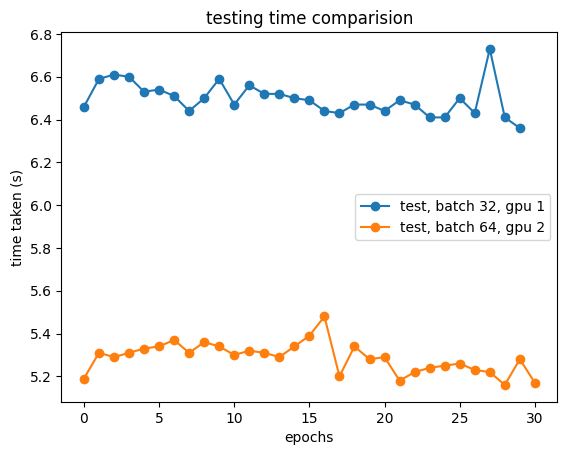

In [15]:
import matplotlib.pyplot as plt
plt.plot(test_1_32, '-o', label = 'test, batch 32, gpu 1')
plt.plot(test_2_64, '-o', label = 'test, batch 64, gpu 2')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('time taken (s)')
plt.title('testing time comparision')
plt.show()

In [27]:
list1 = [x + y for x, y in zip(train_1_32, test_1_32)]
list2 = [x + y for x, y in zip(train_2_64, test_2_64)]
print(list1)
print(list2)

[30.71, 31.61, 31.86, 31.869999999999997, 31.85, 32.09, 32.45, 32.98, 32.870000000000005, 33.04, 32.89, 32.980000000000004, 32.980000000000004, 32.94, 33.14, 33.03, 32.89, 32.5, 32.77, 32.97, 32.79, 32.93, 32.83, 32.769999999999996, 32.82, 32.95, 32.86, 33.07, 32.82, 32.64]
[24.900000000000002, 25.83, 25.91, 25.98, 25.96, 26.04, 25.94, 25.98, 26.15, 25.95, 26.03, 25.81, 25.959999999999997, 26.009999999999998, 26.11, 26.18, 26.3, 25.65, 25.64, 25.650000000000002, 25.529999999999998, 25.72, 25.43, 25.590000000000003, 25.54, 25.479999999999997, 25.47, 25.509999999999998, 25.39, 25.84]


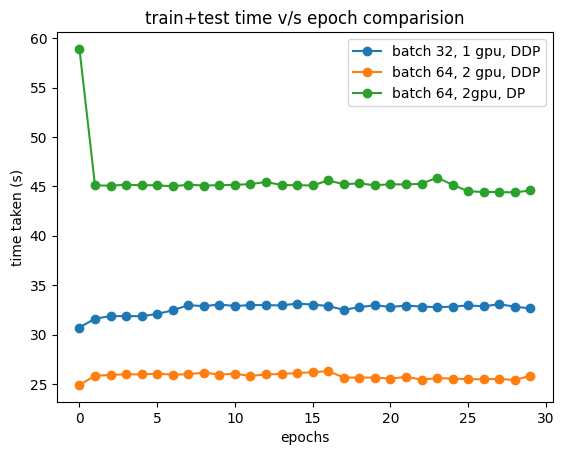

In [28]:
import matplotlib.pyplot as plt
plt.plot(list1, '-o', label = 'batch 32, 1 gpu, DDP')
plt.plot(list2, '-o', label = 'batch 64, 2 gpu, DDP')
plt.plot(train_time_dp, '-o', label = 'batch 64, 2gpu, DP')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('time taken (s)')
plt.title('train+test time v/s epoch comparision')
plt.show()